# Classificação Binária

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot_mpl
init_notebook_mode(connected=True)
cf.go_offline()
import datetime
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

C:\Users\luanc\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1



In [2]:
df = pd.read_csv('./dataset_ic2023.csv', sep = ";")
df.head()

,Colesterol Total,Idade,Glicemia,Desfecho,Unnamed: 4
0,254,38,93,1,NaN
1,222,79,89,-1,NaN
2,236,64,102,-1,NaN
3,241,50,123,-1,NaN
4,167,34,82,-1,NaN


In [3]:
df.shape

(799, 5)

In [4]:
df.isna().sum()

Colesterol Total      0
Idade                 0
Glicemia              0
Desfecho              0
Unnamed: 4          799
dtype: int64

In [5]:
df = df.drop(df.columns[4], axis=1)
df.head()

,Colesterol Total,Idade,Glicemia,Desfecho
0,254,38,93,1
1,222,79,89,-1
2,236,64,102,-1
3,241,50,123,-1
4,167,34,82,-1


In [6]:
df.dtypes

Colesterol Total    int64
Idade               int64
Glicemia            int64
Desfecho            int64
dtype: object

In [7]:
data_ranges = []
for column in df.columns:
    min_value = df[column].min()
    max_value = df[column].max()
    data_ranges.append([column, f"{min_value} - {max_value}"])

ranges_df = pd.DataFrame(data_ranges, columns=['column', 'range'])
print(ranges_df)

             column      range
0  Colesterol Total  150 - 279
1             Idade    10 - 86
2          Glicemia   64 - 169
3          Desfecho     -1 - 1


In [8]:
# Compute the correlation matrix
correlation_matrix = df.corr()

In [9]:
# Define the custom "coolwarm" colormap using RGB values
coolwarm_colors = [
    [0, 'rgb(58, 76, 192)'],
    [0.1, 'rgb(68, 90, 204)'],
    [0.2, 'rgb(77, 104, 215)'],
    [0.3, 'rgb(86, 117, 225)'],
    [0.4, 'rgb(95, 130, 234)'],
    [0.5, 'rgb(139, 151, 255)'],
    [0.6, 'rgb(198, 184, 241)'],
    [0.7, 'rgb(214, 204, 241)'],
    [0.8, 'rgb(229, 224, 242)'],
    [0.9, 'rgb(245, 245, 245)'],
    [1, 'rgb(250, 230, 230)']
]

# Create a heatmap of the correlation matrix using go.Figure
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale=coolwarm_colors,
    zmin=-1,  # Minimum correlation value
    zmax=1,   # Maximum correlation value
    colorbar=dict(title='Correlation'),

))

# Add text annotations manually
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        fig.add_annotation(
            text=str(correlation_matrix.values[i][j].round(2)),
            x=correlation_matrix.columns[j],
            y=correlation_matrix.index[i],
            showarrow=False
        )

# Customize the layout
fig.update_xaxes(side="top")
fig.update_layout(
    title="Correlation Matrix",
    width=600,
    height=600
)

# Show the plot
fig.show()

In [10]:
desfecho_counts = df['Desfecho'].value_counts().reset_index()

# Rename the columns for clarity
desfecho_counts.columns = ['Desfecho', 'Count']
desfecho_counts['Percentage'] = (desfecho_counts['Count']/df.shape[0]).apply(lambda x: f'{x:.2%}')
desfecho_counts

,Desfecho,Count,Percentage
0,-1,535,66.96%
1,1,264,33.04%


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel

# Suponha que você já tenha seus dados carregados em um array numpy chamado 'dados'
# Certifique-se de que 'dados' tenha a seguinte estrutura: idade, colesterol, glicemia, desfecho

# Separar as características (X) e a variável de destino (y)
X = df.drop(columns=['Desfecho'])  # Features (age, total cholesterol, glucose)
y = df['Desfecho']  # Labels (outcome)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a dictionary-based grid of kernels
grid = dict()
#grid['kernel'] = [1*RBF(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]
grid['kernel'] = [1*Matern()]

# Initialize variables to keep track of the best kernel and its corresponding score
best_kernel = None
best_score = 0.0  # Initialize with a low value

# Define the model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# Iterate through the kernels and select the best one based on cross-validation scores
for kernel in grid['kernel']:
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
    mean_cv_score = np.mean(cv_scores)

    # Update the best kernel and score if the current kernel is better
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_kernel = kernel

# Train the best model with the best kernel using the entire training data
best_model = GaussianProcessClassifier(kernel=best_kernel, random_state=0)
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model on the test data
accuracy = accuracy_score(y_test, y_pred)

# Print the best kernel and test results
print("Best Kernel: %s" % best_kernel)
print("Acurácia nos dados de teste: %.3f" % accuracy)


Best Kernel: 1**2 * Matern(length_scale=1, nu=1.5)
Acurácia nos dados de teste: 0.812


In [86]:
# Create a meshgrid for visualization
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
z_min, z_max = X.iloc[:, 2].min() - 1, X.iloc[:, 2].max() + 1
#xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1), np.arange(z_min, z_max, 1))
xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1), X_train.iloc[:,2].median())

grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

c:\Users\luanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names

c:\Users\luanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names

c:\Users\luanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names



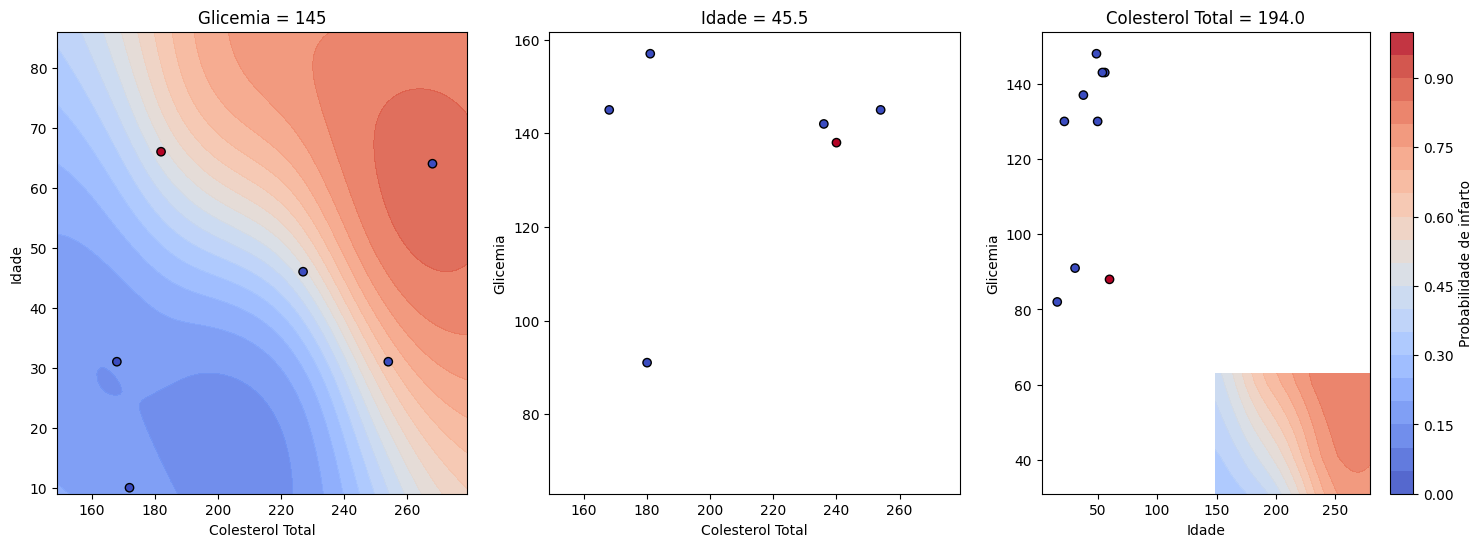

In [100]:
import matplotlib.pyplot as plt

# Create a meshgrid for visualization
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
z_min, z_max = X.iloc[:, 2].min() - 1, X.iloc[:, 2].max() + 1

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    if i == 0:
        xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1), X_test.iloc[:,2].mode())
    elif i == 1:
        xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 1), X_test.iloc[:,1].mode(), np.arange(z_min, z_max, 1))
    else:
        # When i == 2, create a valid 2D grid for the z dimension
        zz = np.full_like(xx, X_test.iloc[:,0].mode().iloc[0])

    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

    # Get predicted probabilities
    probs = best_model.predict_proba(grid_points)[:, 1]
    probs = probs.reshape(xx.shape)

    if i == 0:
        contour = axs[0].contourf(xx[:, :, 0], yy[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 21), cmap=plt.cm.coolwarm, alpha=0.9)
        fig.colorbar(contour, ax=axs[2], label='Probabilidade de infarto')

        x_plot = X_test.loc[X_test.iloc[:, 2] == X_test.iloc[:, 2].mode().iloc[0]]
        axs[i].scatter(x_plot.iloc[:, 0], x_plot.iloc[:, 1], c=y_test[x_plot.index], cmap=plt.cm.coolwarm, edgecolor='k')
        axs[i].set_xlabel(x_plot.columns[0])
        axs[i].set_ylabel(x_plot.columns[1])
        axs[i].set_title(f"{x_plot.columns[2]} = {X_test.iloc[:, 2].mode().iloc[0]}")

    if i == 1:
        contour = axs[1].contourf(xx[:, :, 0], zz[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 21), cmap=plt.cm.coolwarm, alpha=0.9)

        x_plot = X_test.loc[X_test.iloc[:, 1] == X_test.iloc[:, 1].mode().iloc[0]]
        axs[i].scatter(x_plot.iloc[:, 0], x_plot.iloc[:, 2], c=y_test[x_plot.index], cmap=plt.cm.coolwarm, edgecolor='k')
        axs[i].set_xlabel(x_plot.columns[0])
        axs[i].set_ylabel(x_plot.columns[2])
        axs[i].set_title(f"{X_test.columns[1]} = {X_test.iloc[:, 1].median()}")

    elif i == 2:
        contour = axs[2].contourf(xx[:, :, 0], yy[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 21), cmap=plt.cm.coolwarm, alpha=0.9)

        x_plot = X_test.loc[X_test.iloc[:, 0] == X_test.iloc[:, 0].mode().iloc[0]]
        axs[i].scatter(x_plot.iloc[:, 1], x_plot.iloc[:, 2], c=y_test[x_plot.index], cmap=plt.cm.coolwarm, edgecolor='k')
        axs[i].set_xlabel(x_plot.columns[1])
        axs[i].set_ylabel(x_plot.columns[2])
        axs[i].set_title(f"{X_test.columns[0]} = {X_test.iloc[:, 0].median()}")

# Display the subplot
plt.show()


c:\Users\luanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names



(78, 131, 1)


c:\Users\luanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names



(4, 131, 107)


c:\Users\luanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names



(78, 1, 107)


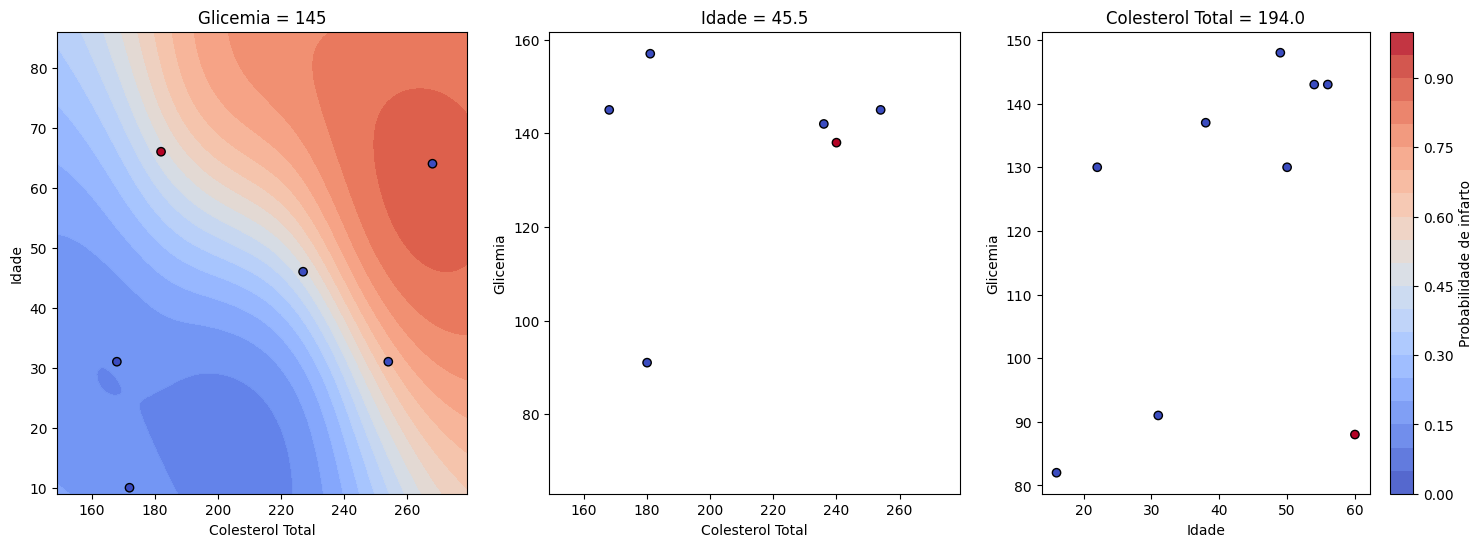

In [99]:
# Create a meshgrid for visualization
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
z_min, z_max = X.iloc[:, 2].min() - 1, X.iloc[:, 2].max() + 1

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    if i == 0:
        xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1), X_test.iloc[:,2].mode())
    
    elif i == 1:
        xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 1), X_test.iloc[:,1].mode(), np.arange(z_min, z_max, 1))
    else:
        xx, yy, zz = np.meshgrid(X_test.iloc[:,0].mode(), np.arange(y_min, y_max, 1), np.arange(z_min, z_max, 1))

    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

    # Get predicted probabilities
    probs = best_model.predict_proba(grid_points)[:, 1]
    probs = probs.reshape(xx.shape)
    

    if i == 0:
        print(probs.shape)
        contour = axs[0].contourf(xx[:, :, 0], yy[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 21), cmap=plt.cm.coolwarm, alpha=0.9) 
        fig.colorbar(contour, ax=axs[2], label='Probabilidade de infarto')

        axs[i].contourf(xx[:, :, 0], yy[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 21), cmap=plt.cm.coolwarm, alpha=0.9)

        x_plot = X_test.loc[X_test.iloc[:, 2] == X_test.iloc[:, 2].mode().iloc[0]]
        axs[i].scatter(x_plot.iloc[:, 0], x_plot.iloc[:, 1], c=y_test[x_plot.index], cmap=plt.cm.coolwarm, edgecolor='k')
        axs[i].set_xlabel(x_plot.columns[0])  
        axs[i].set_ylabel(x_plot.columns[1])  
        axs[i].set_title(f"{x_plot.columns[2]} = {X_test.iloc[:, 2].mode().iloc[0]}")

    if i ==1:
        print(probs.shape)
        axs[i].contourf(xx[:, :, 0], zz[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 21), cmap=plt.cm.coolwarm, alpha=0.9)

        x_plot = X_test.loc[X_test.iloc[:, 1] == X_test.iloc[:, 1].mode().iloc[0]]
        axs[i].scatter(x_plot.iloc[:, 0], x_plot.iloc[:, 2], c=y_test[x_plot.index], cmap=plt.cm.coolwarm, edgecolor='k')
        axs[i].set_xlabel(x_plot.columns[0])  
        axs[i].set_ylabel(x_plot.columns[2])  
        axs[i].set_title(f"{X_test.columns[1]} = {X_test.iloc[:, 1].median()}")

    elif i ==2:
        print(probs.shape)
        #axs[i].contourf(yy[:, :, 0], zz[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 21), cmap=plt.cm.coolwarm, alpha=0.9)

        x_plot = X_test.loc[X_test.iloc[:, 0] == X_test.iloc[:, 0].mode().iloc[0]]
        axs[i].scatter(x_plot.iloc[:, 1], x_plot.iloc[:, 2], c=y_test[x_plot.index], cmap=plt.cm.coolwarm, edgecolor='k')
        axs[i].set_xlabel(x_plot.columns[1])  
        axs[i].set_ylabel(x_plot.columns[2])  
        axs[i].set_title(f"{X_test.columns[0]} = {X_test.iloc[:, 0].median()}")

# Display the subplot
plt.show()

In [87]:
probs = best_model.predict_proba(grid_points)[:, 1]
probs = probs.reshape(xx.shape)

c:\Users\luanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names



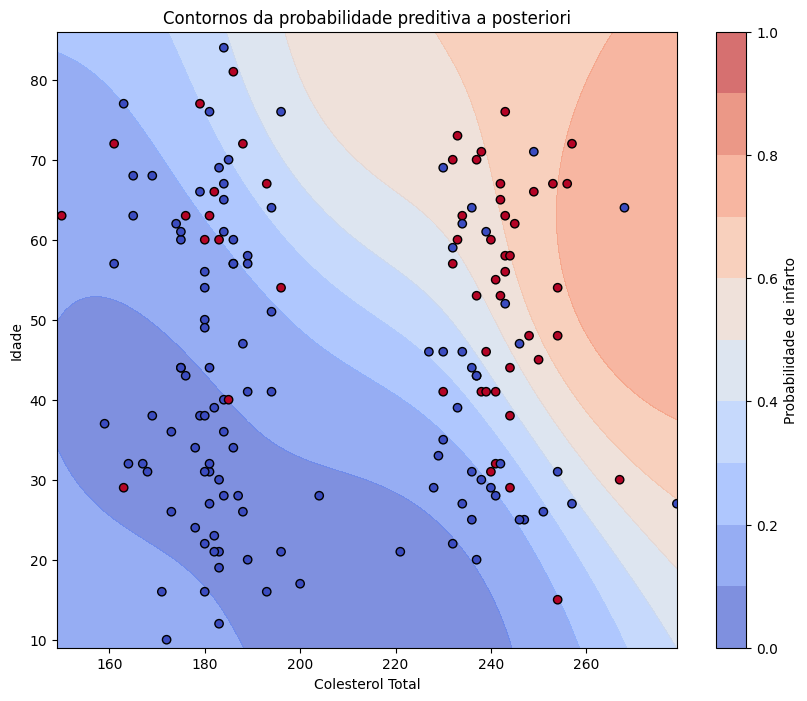

In [89]:
# Create a contour plot of the posterior predictive probability
plt.figure(figsize=(10, 8))
plt.contourf(xx[:, :, 0], yy[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 11), cmap=plt.cm.coolwarm, alpha=0.7)
plt.colorbar(label='Probabilidade de infarto')
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolor='k')
plt.xlabel(X_test.columns[0])  
plt.ylabel(X_test.columns[1])  
plt.title('Contornos da probabilidade preditiva a posteriori')
plt.show()

In [94]:
probs.shape

(78, 131, 1)

In [ ]:
# Create a contour plot of the posterior predictive probability
plt.figure(figsize=(10, 8))
plt.contourf(yy[:, :, 0], zz[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 11), cmap=plt.cm.coolwarm, alpha=0.7)
plt.colorbar(label='Predicted Probability (Class +1)')
plt.scatter(X_test.iloc[:, 1], X_test.iloc[:, 2], c=y_t, cmap=plt.cm.coolwarm, edgecolor='k')
plt.xlabel(X_test.columns[1])
plt.ylabel(X_test.columns[2])
plt.title('Contour of Posterior Predictive Probability')
plt.show()

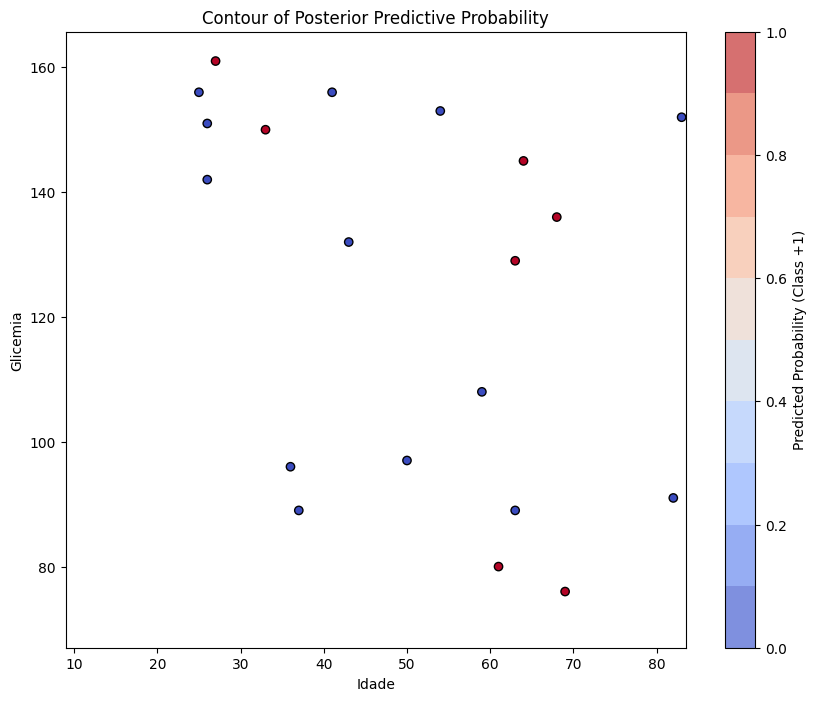

In [ ]:
# Create a contour plot of the posterior predictive probability
plt.figure(figsize=(10, 8))
plt.contourf(yy[:, :, 0], zz[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 11), cmap=plt.cm.coolwarm, alpha=0.7)
plt.colorbar(label='Predicted Probability (Class +1)')
plt.scatter(X_test.iloc[:, 1], X_test.iloc[:, 2], c=y_t, cmap=plt.cm.coolwarm, edgecolor='k')
plt.xlabel(X_test.columns[1])
plt.ylabel(X_test.columns[2])
plt.title('Contour of Posterior Predictive Probability')
plt.show()